Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [ ]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import *
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim
import torchvision
from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
import cv2
imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

c:\Users\aasad\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [230]:
# deJPEG
# fname = 'data/denoising/snail.jpg'

## denoising
fname_noisy = 'VAE-Poiss/FMDD/Single Channel/TwoPhoton_MICE_3.mat'
# fname_clean = 'VAE-Poiss/PolyU/Clean (Mean)/SonyA7II-door-11-mean.mat'
# import cv2

# Load image

For Noisy 1.0 0.0
Noisy Histogram [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [147369  89083  15272   4731   2104   1213    780    487    334    771]
(512, 512)


<Figure size 432x288 with 0 Axes>

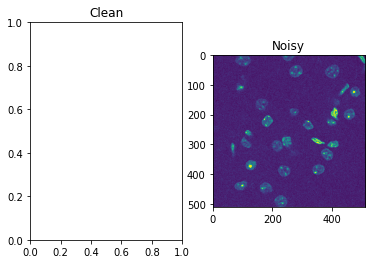

In [231]:
# if fname == 'data/denoising/snail.jpg':
#     img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
#     img_noisy_np = pil_to_np(img_noisy_pil)

#     # As we don't have ground truth
#     img_pil = img_noisy_pil
#     img_np = img_noisy_np

#     if PLOT:
#         plot_image_grid([img_np], 4, 5);

# elif fname == 'data/denoising/F16_GT.png':
    # # Add synthetic noise
    # img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    # img_np = pil_to_np(img_pil)
# min_clean, max_clean = np.min(loadmat(fname_clean)['img'].astype(np.float32)), np.max(loadmat(fname_clean)['img'].astype(np.float32))

# print(max_noisy, min_noisy)
# print(loadmat(fname_clean).keys())
# img_np = loadmat(fname_clean)['img'].astype(np.float64) # for reading mat files
# img_np = cv2.cvtColor(cv2.imread(fname_clean).astype(np.float32), cv2.COLOR_BGR2RGB)
# min_clean, max_clean= np.min(img_np), np.max(img_np)
# img_np= img_np-4
# img=img_np/255.0
# print(img_np)
# img_np = (img_np- min_clean)/(max_clean-min_clean)
# print(img_np)
# hist, bin_edges=np.histogram(img_np)
# print("Clean Histogram",bin_edges,hist)
# print(loadmat(fname_noisy).keys())
img_noisy_np = loadmat(fname_noisy)['noisy'].astype(np.float64)

# img_noisy_np = img_noisy_np * (255/4.5)
min_noisy, max_noisy = np.min(img_noisy_np), np.max(img_noisy_np)
# print(max_noisy-min_noisy)
# img_noisy_np = img_noisy_np/4.5

img_noisy_np = (img_noisy_np- min_noisy)/((max_noisy-min_noisy)) 
# img_noisy_np = cv2.normalize(img_noisy_np.astype("float"), None, 0.0, 1.0, cv2.NORM_MINMAX, -1)
# cv2.imshow("Hello", img_noisy_np)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
print("For Noisy", np.max(img_noisy_np), np.min(img_noisy_np))
# print("For Clean", np.max(img_np), np.min(img_np))
hist, bin_edges=np.histogram(img_noisy_np)
print("Noisy Histogram",bin_edges, hist)

plt.figure()
f, axarr= plt.subplots(1,2)
# axarr[0].imshow(img_np)
axarr[0].set_title("Clean")
axarr[1].imshow(img_noisy_np)
axarr[1].set_title("Noisy")
# img_noisy_np = (img_noisy_np- min_noisy)/((max_noisy-min_noisy)) 
# print(img_np.shape, img_noisy_np.shape)
# img_noisy_np= np.transpose(img_noisy_np,(1,2,0))
# img_np= np.transpose(img_np,(1,2,0))
print(img_noisy_np.shape)

In [232]:
print(fname_noisy.split('.')[0].split('/'))

target_fname= fname_noisy.replace("Noisy", "Denoised/Deep Image Prior").split('.')[0]
print(fname_noisy)
print(target_fname)
# epoch_decider = fname_noisy.split('-')[-1].split('.')[0].replace('p', '.')
# print(epoch_decider)

['VAE-Poiss', 'FMDD', 'Single Channel', 'TwoPhoton_MICE_3']
VAE-Poiss/FMDD/Single Channel/TwoPhoton_MICE_3.mat
VAE-Poiss/FMDD/Single Channel/TwoPhoton_MICE_3


# Setup

In [233]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

# if fname == 'data/denoising/snail.jpg':
num_iter = 1500
# if epoch_decider == "0.0001":
#     num_iter= 1500
# elif epoch_decider == "0.0005":
#     num_iter= 1650
# elif epoch_decider == "0.001":
#     num_iter= 1800
# elif epoch_decider == "0.005":
#     num_iter= 1950
# elif epoch_decider == "0.01":
#     num_iter= 2100
# elif epoch_decider == "0.05":
#     num_iter= 2250
# elif epoch_decider == "0.1":
#     num_iter= 2400
# elif epoch_decider == "0.5":
#     num_iter = 2550 
# elif epoch_decider == "0.8":
#     num_iter= 2700
# elif epoch_decider == "1":
#     num_iter= 3000
# num_iter+=200
# print("Epoch for",epoch_decider,"is",num_iter)
input_depth = 1
figsize = 5

net = skip(
            input_depth, 1,
            num_channels_down = [8, 16, 32, 64, 128],
            num_channels_up   = [8, 16, 32, 64, 128],
            num_channels_skip = [0, 0, 0, 4, 4],
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)
# print(type (net))
# elif fname == 'data/denoising/F16_GT.png':
#     num_iter = 3000
#     input_depth = 32
#     figsize = 4


#     net = get_net(input_depth, 'skip', pad,
#                   skip_n33d=128,
#                   skip_n33u=128,
#                   skip_n11=4,
#                   num_scales=5,
#                   upsample_mode='bilinear').type(dtype)

# else:
#     assert False
# print(img_np.shape)
net_input = get_noise(input_depth, INPUT, (img_noisy_np.shape[0], img_noisy_np.shape[1])).type(dtype).detach()
print(net_input.shape)
# print(net_input)
# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)
# print(mse)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
# img_noisy_torch = torch.transpose(img_noisy_torch, 1, 3)
# print(img_noisy_torch.shape)



torch.Size([1, 1, 512, 512])
Number of params: 572665


# Optimize

Starting optimization with ADAM


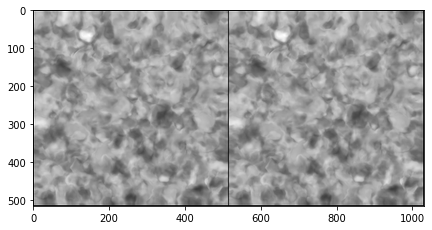

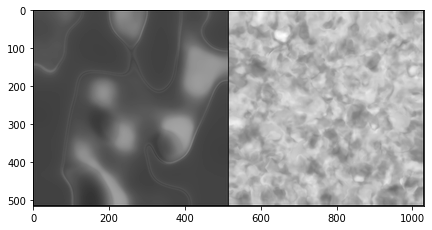

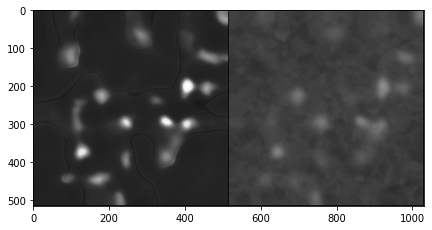

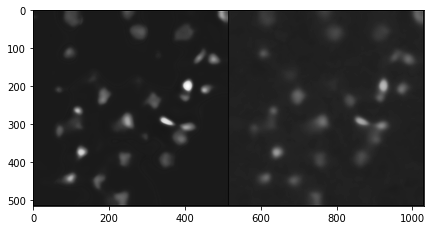

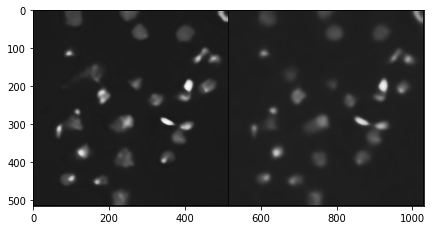

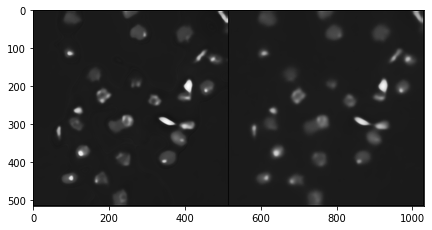

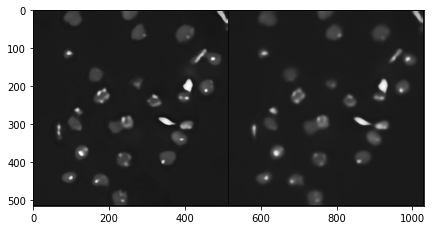

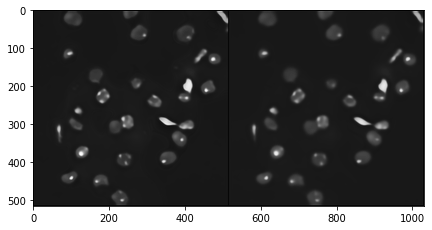

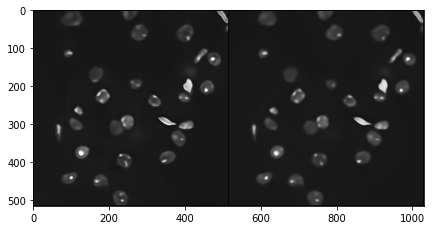

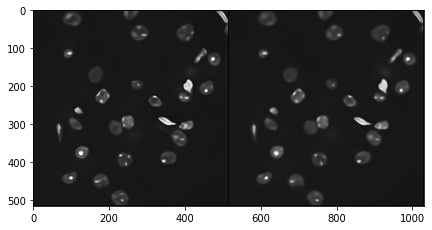

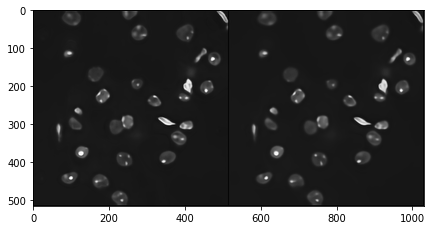

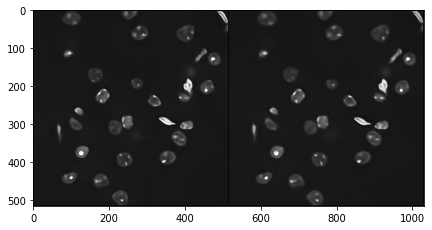

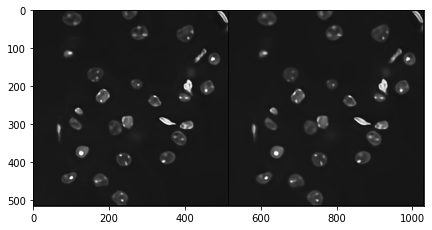

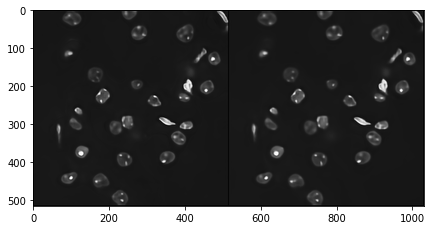

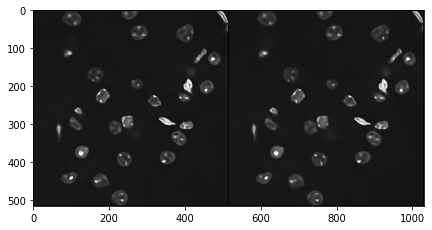

In [234]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    # print("ni",net_input.shape)
    transform = torchvision.transforms.Resize((net_input.shape[-2], net_input.shape[-1]))
    out = net(net_input)
    out= transform(out)
    # print(out.shape)
    # print("out",out.detach().shape)
    # print("net",net_input.shape)
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
    # print("out_avg",out_avg.shape)

    # print("img n torch",img_noisy_torch.shape)
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
    # img_noisy_np= np.transpose(img_noisy_np,(1,2,0))
    # img_np= np.transpose(img_np,(1,2,0))
    # print("odnumpy",out.detach().cpu().numpy().shape)
    odnp=out.detach().cpu().numpy()[0]
    # odnp= odnp.transpose(1,2,0)
    # print(odnp.shape)
    oanp=out_avg.detach().cpu().numpy()[0]
    # print(oanp.dtype)
    # oanp=oanp.transpose(1,2,0)
    psrn_noisy = 0.0 #peak_signal_noise_ratio(img_noisy_np, odnp)
    psrn_gt    =0.0 #peak_signal_noise_ratio(img_np, odnp)
    psrn_gt_sm = 0.0#peak_signal_noise_ratio(img_np, oanp)

    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense hence printing 0.0 in no GT case
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        
        # print("Yes", out_np.shape)
        plot_image_grid([np.clip(out_np, 0, 1),
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=2)



    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [235]:
# print(type(out_avg))
savemat(target_fname+"-dip.mat",{"Denoised": (torch_to_np(out_avg)).transpose(1,2,0)})

In [ ]:
# out_np = torch_to_np(net(net_input))
# q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13)